In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


We first convert the images to tensors, then normalize it with given values
The first tuple: (0.4914, 0.4822, 0.4465) is the mean for each of the three color channels: Red, Green, Blue.
The second tuple: (0.2023, 0.1994, 0.2010) is the standard deviation for each channel

In [15]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),  # data augmentation part added for improvement
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
#Converting to tensor already scales pixels to [0, 1].
#Normalization further centers and scales each channel, which is the standard practice for most deep learning pipelines.

Loading the dataset using the torchvision.CIFAR class
Then taking batches of data, shuffles it for training purpose

In [16]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,)

Same for test data

In [17]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

We will now set up the CNN architecture
MyCNN class would hold the architecture. 3 Conv layers are used.

In [18]:
dropout_rate = 0.3
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()  # init basically defines the architecture
    self.conv1 = nn.Conv2d(3,32,kernel_size = 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,64, kernel_size = 3, padding = 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64,128, kernel_size = 3, padding = 1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,256, kernel_size = 3, padding = 1)
    self.bn4 = nn.BatchNorm2d(256)
    self.pool = nn.MaxPool2d(2,2)  # pooling is done for downsampling to reduce the spatial size , retain imp info, decreases no. of parameters
    self.fc1 = nn.Linear(256*16*16, 256) # fully connected layer 1 takes the input from pooling and outputs 256 features
    self.dropout = nn.Dropout(dropout_rate)
    self.fc2 = nn.Linear(256, 10) # maps the 256 features to 10 CIFAR classes
    self.relu = nn.ReLU()

  def forward(self, x):  # forward pass defines in which way data flows through the architecture
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.pool(x)
    x = x.view(-1, 256 * 16 * 16) #flattening step
    x = self.dropout(self.relu(self.fc1(x)))
    x = self.fc2(x)
    return x

# Instantiate the model
net = MyCNN()

Setting up the training prerequisites

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) # all parameters of net, lr is learning rate

Model Training

In [20]:
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #trainloader loads all the batches
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

[1, 100] loss: 2.208
[1, 200] loss: 1.912
[1, 300] loss: 1.801
[1, 400] loss: 1.744
[1, 500] loss: 1.707
[1, 600] loss: 1.664
[1, 700] loss: 1.619
[2, 100] loss: 1.556
[2, 200] loss: 1.536
[2, 300] loss: 1.515
[2, 400] loss: 1.484
[2, 500] loss: 1.474
[2, 600] loss: 1.445
[2, 700] loss: 1.435
[3, 100] loss: 1.375
[3, 200] loss: 1.399
[3, 300] loss: 1.388
[3, 400] loss: 1.364
[3, 500] loss: 1.338
[3, 600] loss: 1.353
[3, 700] loss: 1.378
[4, 100] loss: 1.287
[4, 200] loss: 1.299
[4, 300] loss: 1.322
[4, 400] loss: 1.286
[4, 500] loss: 1.299
[4, 600] loss: 1.279
[4, 700] loss: 1.315
[5, 100] loss: 1.300
[5, 200] loss: 1.254
[5, 300] loss: 1.253
[5, 400] loss: 1.254
[5, 500] loss: 1.237
[5, 600] loss: 1.245
[5, 700] loss: 1.225
[6, 100] loss: 1.250
[6, 200] loss: 1.232
[6, 300] loss: 1.233
[6, 400] loss: 1.221
[6, 500] loss: 1.226
[6, 600] loss: 1.204
[6, 700] loss: 1.223
[7, 100] loss: 1.211
[7, 200] loss: 1.191
[7, 300] loss: 1.222
[7, 400] loss: 1.189
[7, 500] loss: 1.190
[7, 600] loss

Validation

Model Evaluation

In [21]:
correct = 0
total = 0
net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # if using GPU
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 76.83%


Computing Predictions and labels

In [22]:

from sklearn.metrics import confusion_matrix, classification_report

# Collect all predictions and targets
all_preds = []
all_labels = []

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Plotting confusion matrix

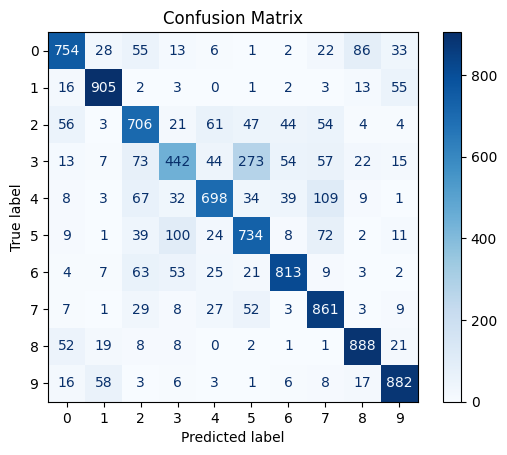

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Classification report

In [24]:
from sklearn.metrics import classification_report

target_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.81      0.75      0.78      1000
  automobile       0.88      0.91      0.89      1000
        bird       0.68      0.71      0.69      1000
         cat       0.64      0.44      0.52      1000
        deer       0.79      0.70      0.74      1000
         dog       0.63      0.73      0.68      1000
        frog       0.84      0.81      0.82      1000
       horse       0.72      0.86      0.78      1000
        ship       0.85      0.89      0.87      1000
       truck       0.85      0.88      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000

